### Download Necessary Files

In [2]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkstats2.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkplot.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/nsfg.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/survival.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemResp.dct")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemResp.dat.gz")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2006_2010_FemRespSetup.dct")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2006_2010_FemResp.dat.gz")

In [3]:
import warnings
warnings.filterwarnings('ignore')

## Excercise 13.1

In [4]:
# Function for Century Month to Year conversion
import pandas as pd

def century_month_to_year(century_month):
    return 1900 + (century_month // 12)

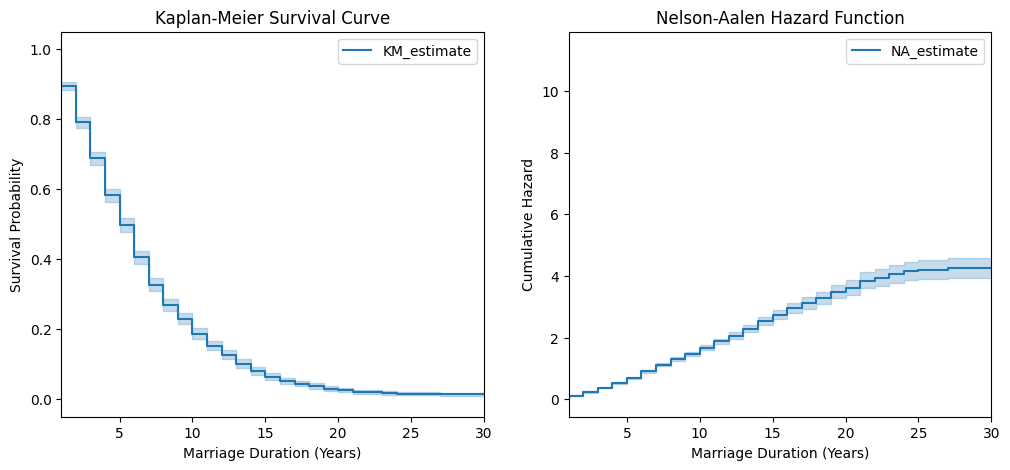

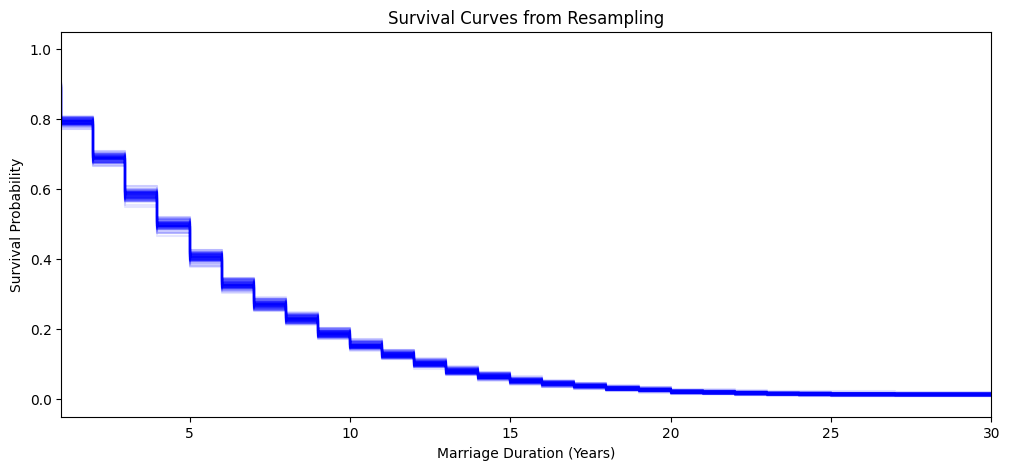

In [5]:
import survival
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter, NelsonAalenFitter

# Read data for cycle 6 and 7
resp6 = survival.ReadFemResp2002()
resp7 = survival.ReadFemResp2010()

#Combine data
df = pd.concat([resp6, resp7])
df = df.dropna(subset=['cmmarrhx'])
df = df.dropna(subset=['cmdivorcx'])

# Define columns
marry_col = "cmmarrhx"  # Century-month of first marriage
divorce_col = "cmdivorcx"  # Century-month of divorce
current_time = df[marry_col].max()  # Approximate current time in century months


# Convert century-months to years
df["marry_year"] = df[marry_col].apply(century_month_to_year).astype(int)
df["divorce_year"] = df[divorce_col].apply(century_month_to_year).astype(int)
current_year = int(century_month_to_year(current_time))  # Convert current time to years

# Compute Marriage Duration in Years
df["duration_years"] = np.where(df["divorce_year"].notna(), 
                                df["divorce_year"] - df["marry_year"],  # Divorced cases
                                current_year - df["marry_year"])       # Ongoing marriages

# Create Event Indicator (1 if divorced, 0 if still married)
df["event"] = df[divorce_col].notna().astype(int)

# Initialize Kaplan-Meier and Nelson-Aalen estimators
kmf = KaplanMeierFitter()
naf = NelsonAalenFitter()

# Fit models to data
kmf.fit(durations=df["duration_years"], event_observed=df["event"])
naf.fit(durations=df["duration_years"], event_observed=df["event"])

# Plot Survival and Hazard Functions
plt.figure(figsize=(12, 5))

# Survival Curve
plt.subplot(1, 2, 1)
ax=kmf.plot_survival_function()
ax.set_xlim(1, 30) 
plt.title("Kaplan-Meier Survival Curve")
plt.xlabel("Marriage Duration (Years)")
plt.ylabel("Survival Probability")

# Hazard Curve
plt.subplot(1, 2, 2)
na=naf.plot_cumulative_hazard()
na.set_xlim(1, 30) 
plt.title("Nelson-Aalen Hazard Function")
plt.xlabel("Marriage Duration (Years)")
plt.ylabel("Cumulative Hazard")

plt.show()

# Resampling with Bootstrapping for Sampling Weights
n_samples = 100
plt.figure(figsize=(12, 5))

for _ in range(n_samples):
    sample = df.sample(frac=1, replace=True)  # Bootstrap Resampling
    kmf.fit(durations=sample["duration_years"], event_observed=sample["event"])
    plt.step(kmf.timeline, kmf.survival_function_, alpha=0.1, color='blue')

plt.xlim(1, 30)
plt.title("Survival Curves from Resampling")
plt.xlabel("Marriage Duration (Years)")
plt.ylabel("Survival Probability")
plt.show()

### Findings
- The risk of divorce is highest in the first 10 years of marriage.
- After 20–25 years, the divorce rate slows significantly.
- The Nelson-Aalen function supports this by showing a rapid accumulation of risk early on, which plateaus later.
- Resampling confirms trends: Even with multiple resampled datasets, the overall trend remains consistent.

### Segmenting based on Age of Marriage


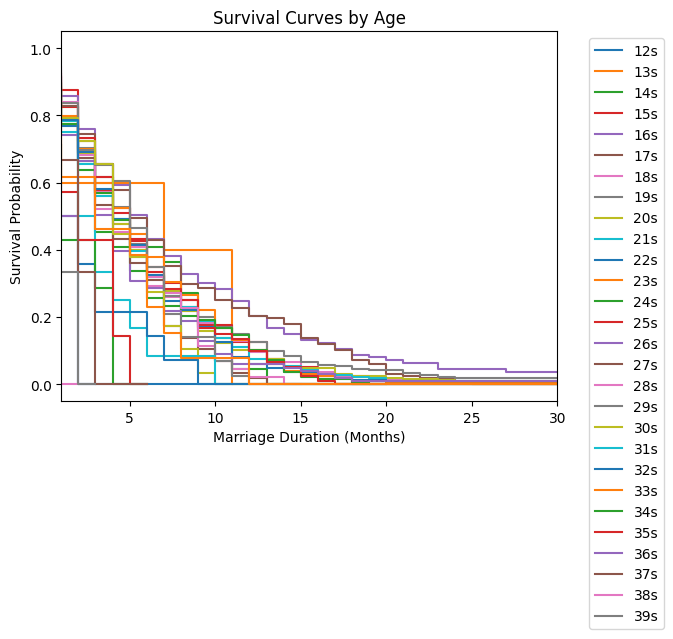

In [26]:
df["age_marry"] = df["agemarry"].astype(int)
for age, group in df.groupby("age_marry"):
     kmf.fit(durations=group["duration_years"], event_observed=group["event"])
     plt.step(kmf.timeline, kmf.survival_function_, label=f"{age}s")

plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.xlim(1, 30)
plt.title("Survival Curves by Age")
plt.xlabel("Marriage Duration (Months)")
plt.ylabel("Survival Probability")
plt.show()

### Findings
- Younger individuals (e.g., teens, early 20s) tend to have lower survival probabilities and higher divorce rates early on.
- Older individuals (late 20s, 30s) may experience more stable marriages, as their survival curves appear to decline more gradually.
- The variation between age groups suggests that age at marriage plays a significant role in marital stability.